# nmi | spring 2024
## lecture 16 : multi-step


### 6.7 multipstep


bc RK family is one-step bc $w_{i+1}$ relies on $w_i$.

#### 6.7.1 generating multistep


##### <b>adams-bashforth two-step</b>


$$w_{i+1} = w_i + h\left[ \frac{3}{2}f(t_i,w_i) - \frac{1}{2}f(t_{i-1},w_{i-1}) \right].$$
</br>


##### usw




midpoint, 2nd order
</br></br>

$$w_{i+1} = w_i + hf\left( t_i + \frac{h}{2},w_i + \frac{h}{2}f(t_i,w_i) \right).$$\
</br>

makes two $f$ calls, while the former needs only one additional. and its order two. ie, same order, less ops.
</br></br>

however, multistep methods need prep. ie, if $w_{i+1}$ relies on $w_i,w_{i-1},w_{i-2},\dots$. eg, adams-bashforth $w_2$ needs $w_1,w_0$.
</br>


###### code


In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [ ]:
# from previous lectures

# solver: order 2, trapezoid
def trap_step(t,y,h,ydot):
  s1 = ydot(t,y)
  s2 = ydot(t+h,y+h*s1)
  rc = y+h/2*(s1+s2)
  return rc

# ivp: f(t,y)
ydot = lambda t,y: t*y + pow(t,3) # eg 6.1




ab 2step, h=0.05



,t,y,f,u,u_f,w,w_f
0,0.00,1.00000,0.00000,1.00000,0.00000,1.00000,0.00000
1,0.05,1.00125,0.05019,1.00125,0.05019,1.00125,0.05019
2,0.10,1.00502,0.10150,1.00502,0.10150,1.00502,0.10150
3,0.15,1.01138,0.15508,1.01143,0.15509,1.01140,0.15509
4,0.20,1.02047,0.21209,1.02054,0.21211,1.02053,0.21211
...,...,...,...,...,...,...,...
16,0.80,1.48726,1.70181,1.40979,1.63983,1.48956,1.70365
17,0.85,1.57795,1.95538,1.73809,2.09150,1.58070,1.95772
18,0.90,1.68205,2.24285,1.38392,1.97453,1.68533,2.24580
19,0.95,1.80138,2.56869,2.39135,3.12916,1.80528,2.57239


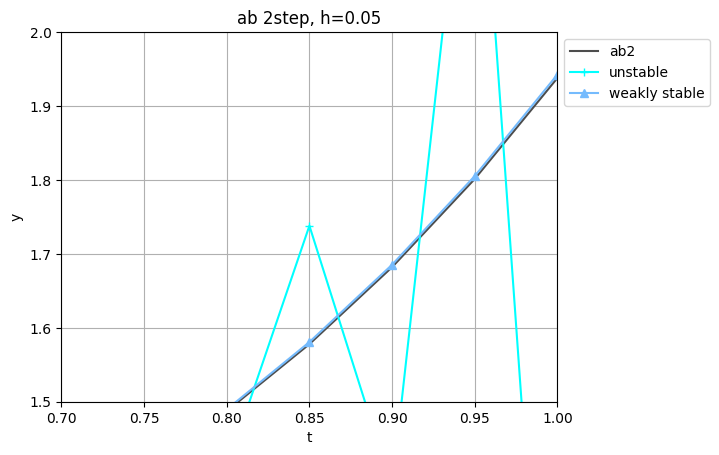

In [ ]:
# program 6.7 multistep

# one step of the Adams-Bashforth 2-step method
ab2step = lambda t,i,y,f,h: y[i] + h/2*(3*f[i] - f[i-1])

# one step of an unstable 2-step method
unstable2step = lambda t,i,y,f,h: -y[i] + 2*y[i-1] + h/2*(5*f[i] + f[i-1])

# one step of a weakly-stable 2-step method
weaklystable2step = lambda t,i,y,f,h: y[i-1] + h*2*f[i]

# ivp: ic,t
ic = 1.
t = [0.,1.]

# n partitions of step-size h
h = 0.05
n = round((t[1]-t[0])/h)
n_steps = 2

ds = np.zeros((n+1,7)) # t,[y,f]x(ab,un,ws)
ds_t,ds_y,ds_f = T,Y,F = 0,1,2
ds_u,ds_uf = UNSTABLE,UNSTABLE_f = 3,4
ds_w,ds_wf = WEAK,WEAK_f = 5,6

# start-up, n_steps
ds[0,:] = [t[0],ic,np.nan,ic,np.nan,ic,np.nan]
for i in range(n_steps-1):
  ds[i+1,T] = ds[i,T] + h
  ds[i+1,Y] = trap_step(ds[i,T],ds[i,Y],h,ydot)
  ds[i  ,F] = ydot(ds[i,T],ds[i,Y])

  ds[i+1,UNSTABLE]   = ds[i+1,WEAK]   = ds[i+1,Y]
  ds[i  ,UNSTABLE_f] = ydot(ds[i,T],ds[i,UNSTABLE])
  ds[i  ,WEAK_f]     = ydot(ds[i,T],ds[i,WEAK])

# multi-step, after n_steps
for i in range(n_steps-1,n):
  ds[i+1,T] = ds[i,T] + h
  ds[i  ,F] = ydot(ds[i,T],ds[i,Y])
  ds[i+1,Y] = ab2step(ds[:,T],i,ds[:,Y],ds[:,F],h)

  ds[i  ,UNSTABLE_f] = ydot(ds[i,T],ds[i,UNSTABLE])
  ds[i+1,UNSTABLE] = unstable2step(ds[:,T],i,ds[:,UNSTABLE],ds[:,UNSTABLE_f],h)
  ds[i  ,WEAK_f] = ydot(ds[i,T],ds[i,WEAK])
  ds[i+1,WEAK] = weaklystable2step(ds[:,T],i,ds[:,WEAK],ds[:,WEAK_f],h)

# dataframe from datastore
s_title = "ab 2step, h=" + str(h)
print(f"\n\n"+s_title+"\n") # bc pf.style.set_caption() bites in colab atm
pd.set_option("display.max_rows",10)
pd.set_option("display.precision",5)
df = pd.DataFrame(data=ds,columns=["t","y","f","u","u_f","w","w_f"])
if True: # spreadsheet
  display(df)

if True: # plot
  ax1  = df.plot(x="t",y="y",label="ab2",color=".3")
  #ax11 = df.plot(x="t",y="f",label="y'",ax=ax1,color="xkcd:sky blue",marker="*")
  ax12 = df.plot(x="t",y="u",label="unstable",ax=ax1,color="cyan",marker="+")
  ax13 = df.plot(x="t",y="w",label="weakly stable",ax=ax1,color="xkcd:sky blue",marker="^")
  ax1.set_title(s_title)
  ax1.set_xlabel("t")
  ax1.set_ylabel("y")
  ax1.axis((.7,1,1.5,2))
  ax1.grid('on',which='major',axis='x')
  ax1.grid('on',which='major',axis='y')
  plt.legend(bbox_to_anchor=(1,1))
  plt.show()

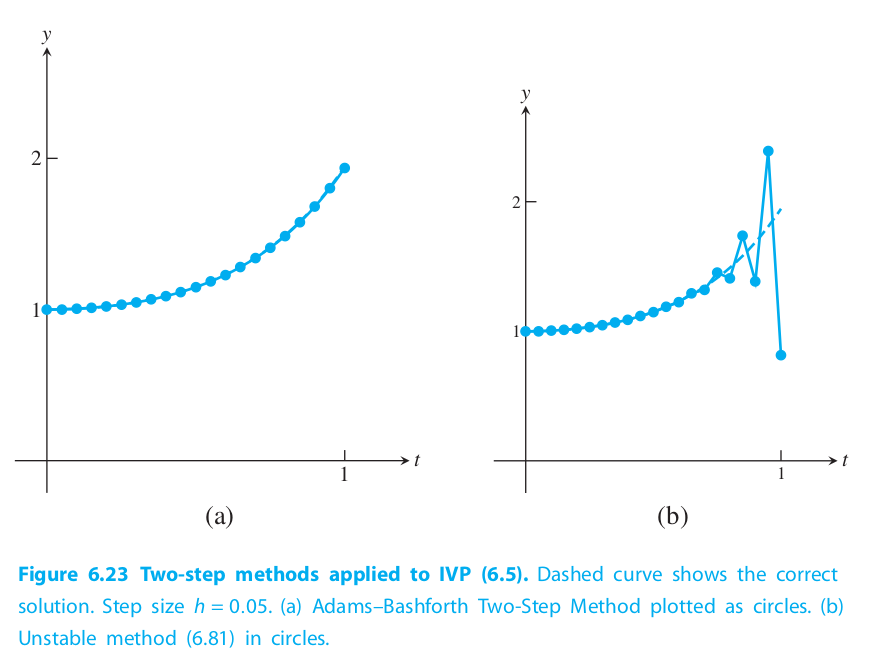

##### usw


general form for $s$-step method:
</br></br>

$$w_{i+1} = a_1w_i + a_2w_{i-1} + \dots + a_sw_{i-s+1} + h[b_0f_{i+1} + b_1f_i + b_2f_{i-1} + \dots + b_sf_{i-s+1}]$$
</br>

with step-size $h$ and where $f_i \equiv f(t_i,w_i)$. if $b_0 = 0$, the method is explicit; if $b_0 \ne 0$, implicit.
</br></br>

for $s=2$,
</br></br>

\begin{align}
  w_{i+1} &= a_1w_i + a_2w_{i-1} + h[b_0f_{i+1} + b_1f_i + b_2f_{i-1}]. \\
  \\
  &\quad\Downarrow\text{taylors method} \\
  \\
  &= a_1[y_1] \\
  &\qquad + a_2[y_i - hy_1' + \frac{h^2}{2!}y_i'' - \frac{h^3}{3!}y_i''' + \frac{h^4}{4!}y_i^{(iv)} - \dots] \\
  &\qquad + b_0[\qquad hy_1' + h^2y_i'' + \frac{h^3}{2!}y_i''' + \frac{h^4}{3!}y_i^{(iv)} + \dots] \\
  &\qquad + b_1[\qquad hy_1'] \\
  &\qquad + b_2[\qquad hy_1' - h^2y_i'' + \frac{h^3}{2!}y_i''' - \frac{h^4}{3!}y_i^{(iv)} + \dots] \\
  \\
  &\quad\Downarrow \\
  \\
  w_{i+1} &= (a_1+a_2)y_i + (b_0+b_1+b_2-a_2)hy_i'+(a_2-2b_2+2b_0)\frac{h^2}{2!}y_i'' + (3b_0+3b_2-a_2)\frac{h^3}{3!}y_i''' + (a_2+4b_0-4b_2)\frac{h^4}{4!}y_i^{(iv)} + \dots
\end{align}
</br>

choose $a_i$, $b_i$ to minimize local truncation error, $y_{i+1} - w_{i+1}$, where
</br>

$$y_{i+1} = y_i + hy_i + \frac{h^2}{2!}y_i'' + \frac{h^3}{3!}y_i''' + \dots.$$
</br>


#### 6.7.2 explicit multistep


for explicit multi-step, set $b_0 = 0$. match terms up to and including $h^2$ for the previous local truncation error for a valuation of $\mathcal{O}(h^3)$.
</br></br>

\begin{align}
  a_1 + a_2 &= 1 \\
  -a_2 + b_1 + b_2 &= 1 \\
  a_2 - 2b_2 &= 1.
\end{align}
</br>

which is three equations in four unknowns. rewrite in terms of $a_1$.
</br></br>

\begin{align}
  a_2 &= 1 - a_1 \\
  b_1 &= 2 - \frac{1}{2}a_1 \\
  b_2 &= -\frac{1}{2}a_1.
\end{align}
</br>

local truncation error is now
</br></br>

\begin{align}
  y_{i+1} - w{i+1} &= \frac{h^3}{3!}y_i''' - (3b_2-a_2)\frac{h^3}{3!}y_i''' + \mathcal{O}(h^4) \\
  &= (1 - 3b_2 + a_2)\frac{h^3}{3!}y_i''' + \mathcal{O}(h^4) \\
  &= \frac{4+a_1}{12}h^3y_i''' + \mathcal{O}(h^4).
\end{align}
</br>

and any choice $a_1$ will return an order two method.
</br></br>

eg, $a_1 = 1$ yields adams-bashforth: $a_2 = 0$, $b_1 = \frac{3}{2}$, $b_2 = -\frac{1}{2}$ and local truncation error is $\frac{5}{12}h^3y'''(t_i) + \mathcal{O}(h^4)$.
</br></br>

eg, $a_1 = \frac{1}{2}$ yields some other method: $a_2 = \frac{1}{2}$, $b_1 = \frac{7}{4}$, $b_2 = -\frac{1}{4}$ and local truncation error is $\frac{3}{8}h^3y'''(t_i) + \mathcal{O}(h^4)$.
</br></br>

$$w_{i+1} = \frac{1}{2}w_i + \frac{1}{2}w_{i-1} + h\left[ \frac{7}{4}f_i - \frac{1}{4}f_{i-1} \right].$$
</br>


after the initial prep, multi-step needs one new evaluation for each subsequent step while one-step methods generally need more. eg, RK4 needs four evaluations per step while order four adams-bashford needs one per step after its set-up.
</br>


so, sure on any $a_1$ but are they any good?
</br></br>

eg, $a_1 = -1$ yields yet another method: $a_2 = 2$, $b_1 = \frac{5}{2}$, $b_2 = \frac{1}{2}$.
</br></br>

$$w_{i+1} = -w_i + 2w_{i-1} + h\left[ \frac{5}{2}f_i + \frac{1}{2}f_{i-1} \right].$$
</br>

thats the unstable equation plotted earlier in comparison to adams-bashforth.
</br></br>

further, consider IVP
</br></br>

\begin{align}
  \textrm{eg simple} \quad
  \left\{ \quad
    \begin{array}{l}
      y' = 0 \\
      y(0) = 0 \\
      t \in [0,1]
    \end{array}
  \right.
\end{align}
</br>

using the previous $a_1 = -1$ multistep,
</br></br>

$$w_{i+1} = -w_i + 2w_{i-1} + h[0].$$
</br>

so $\{w_i\} \equiv 0$. among others. ie, with $w_i = c\lambda^i$
</br></br>

\begin{align}
  c\lambda^{i+1} + c\lambda - 2c\lambda^{i-1} &= 0 \\
  c\lambda^{i-1}(\lambda^2 + \lambda - 2) &= 0.
\end{align}
</br>

the solutions of the characteristic polynomial $\lambda^2 + \lambda - 2$ are $1,-2$. the latter means that solutions of form $(-2)^ic$ are solutions of the method for constant $c$. notation aside, it means small rounding and truncation errors may grow to swamp the computation. ie, the roots of the characterist polynomial shouild be bounded by $1$ in absolute value.

##### <b><font color=grey>definition 06</font> stable</b>


multistep is <b>stable</b> if the roots of polynomial $P(x) = x^s - a_1x^{s-1} - \dots - a_s$ are bounded by $1$ in absolute value and any roots of absolute value $1$ are simple roots. a stable method for which $1$ is the only root of absolute value $1$ is called <b>strongly stable</b>; else it is <b>weakly stable</b>.
</br>

##### usw


eg, adams-bashforth has roots $0,1$ making it strongly stable while the method with $a_1 = -1$ has roots $-2,1$ making it unstable.
</br></br>

also, wrt general two-step,
</br></br>

\begin{align}
  P(x) &= x^2 - a_1 - a_2 \\
  &= x^2 - a_1x - 1 + a_1 \\
  &= (x-1)(x-a_1 + 1),
\end{align}
</br>

whose roots are $1,a_1 - 1$. ie, setting $a_1 = 0$ results in roots $-1,1$ which is the weakly stable order two method:
</br></br>

$$w_{i+1} = w_{i-1} + 2hf_i.$$
</br>


##### example 26


IVP
</br></br>

\begin{align}
  \textrm{example 26} \quad
  \left\{ \quad
    \begin{array}{l}
      y' = -3y \\
      y(0) = 1 \\
      t \in [0,2]
    \end{array}
  \right.
\end{align}
</br>

with solution $y=e^{-3t}$.
</br>


###### code


In [ ]:
# from previous lectures

# solver: order 2, trapezoid
def trap_step(t,y,h,ydot):
  s1 = ydot(t,y)
  s2 = ydot(t+h,y+h*s1)
  rc = y+h/2*(s1+s2)
  return rc

# ivp: f(t,y)
ydot = lambda t,y: -3*y # eg 25




ab 2step, h=0.05



,t,y,f,u,u_f,w,w_f
0,0.00,1.00000,-3.00000,1.00000e+00,-3.00000e+00,1.00000,-3.00000
1,0.05,0.86125,-3.00000,8.61250e-01,-3.00000e+00,0.86125,-3.00000
2,0.10,0.71125,-2.58375,6.88750e-01,-2.58375e+00,0.70000,-2.58375
3,0.15,0.59247,-2.13375,6.35781e-01,-2.06625e+00,0.60288,-2.10000
4,0.20,0.49703,-1.77741,4.18844e-01,-1.90734e+00,0.49000,-1.80863
...,...,...,...,...,...,...,...
36,1.80,0.00176,-0.00631,-4.93777e+07,-7.86366e+07,0.00163,-0.00601
37,1.85,0.00148,-0.00529,9.30162e+07,1.48133e+08,0.00140,-0.00489
38,1.90,0.00124,-0.00443,-1.75221e+08,-2.79049e+08,0.00114,-0.00421
39,1.95,0.00104,-0.00371,3.30076e+08,5.25663e+08,0.00098,-0.00342


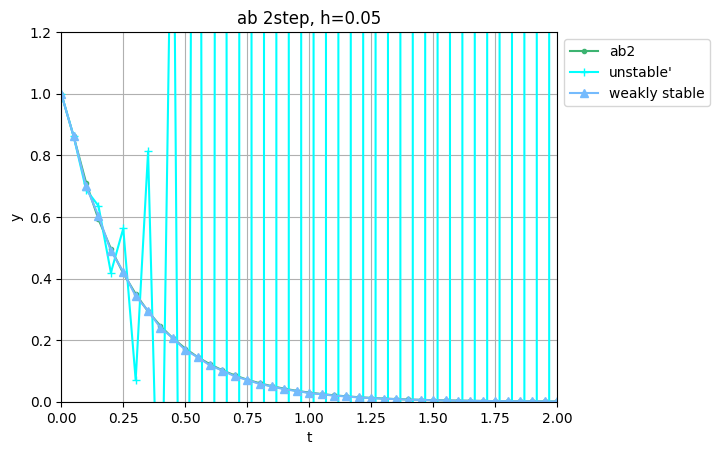

In [ ]:
# eg 25

# one step of the Adams-Bashforth 2-step method
ab2step = lambda t,i,y,f,h: y[i] + h/2*(3*f[i] - f[i-1])

# one step of an unstable 2-step method
unstable2step = lambda t,i,y,f,h: -y[i] + 2*y[i-1] + h/2*(5*f[i] + f[i-1])

# one step of a weakly-stable 2-step method
weaklystable2step = lambda t,i,y,f,h: y[i-1] + h*2*f[i]

# ivp: ic,t
ic = 1.
t = [0.,2.]

# n partitions of step-size h
h = 0.05
n = round((t[1]-t[0])/h)
n_steps = 2

ds = np.zeros((n+1,7)) # t,[y,f]x(ab,un,ws)
ds_t,ds_y,ds_f = T,Y,F = 0,1,2
ds_u,ds_uf = UNSTABLE,UNSTABLE_f = 3,4
ds_w,ds_wf = WEAK,WEAK_f = 5,6

# start-up, n_steps
y_ic = ydot(t[0],ic)
ds[0,:] = [t[0],ic,y_ic,ic,y_ic,ic,y_ic]
for i in range(n_steps-1):
  ds[i+1,T] = ds[i,T] + h
  ds[i+1,Y] = trap_step(ds[i,T],ds[i,Y],h,ydot)
  ds[i+1,F] = ydot(ds[i,T],ds[i,Y])

  ds[i+1,UNSTABLE] = ds[i+1,WEAK] = ds[i+1,Y]
  ds[i+1,UNSTABLE_f] = ds[i+1,WEAK_f] = ds[i+1,F]

# multi-step, after n_steps
for i in range(n_steps-1,n):
  ds[i+1,T] = ds[i,T] + h
  ds[i+1,Y] = ab2step(ds[:,T],i,ds[:,Y],ds[:,F],h)
  ds[i+1,F] = ydot(ds[i,T],ds[i,Y])

  ds[i+1,UNSTABLE] = unstable2step(ds[:,T],i,ds[:,UNSTABLE],ds[:,UNSTABLE_f],h)
  ds[i+1,UNSTABLE_f] = ydot(ds[i,T],ds[i,UNSTABLE])
  ds[i+1,WEAK] = weaklystable2step(ds[:,T],i,ds[:,WEAK],ds[:,WEAK_f],h)
  ds[i+1,WEAK_f] = ydot(ds[i,T],ds[i,WEAK])

# dataframe from datastore
s_title = "ab 2step, h=" + str(h)
print(f"\n\n"+s_title+"\n") # bc pf.style.set_caption() bites in colab atm
pd.set_option("display.max_rows",10)
pd.set_option("display.precision",5)
df = pd.DataFrame(data=ds,columns=["t","y","f","u","u_f","w","w_f"])
if True: # spreadsheet
  display(df)

if True: # plot
  ax1  = df.plot(x="t",y="y",label="ab2",color="mediumseagreen",marker=".")
  #ax11 = df.plot(x="t",y="f",label="y'",ax=ax1,color="xkcd:sky blue",marker="*")
  ax12 = df.plot(x="t",y="u",label="unstable'",ax=ax1,color="cyan",marker="+")
  ax13 = df.plot(x="t",y="w",label="weakly stable",ax=ax1,color="xkcd:sky blue",marker="^")
  ax1.set_title(s_title)
  ax1.set_xlabel("t")
  ax1.set_ylabel("y")
  ax1.axis((0,2,0,1.2))
  ax1.grid('on',which='major',axis='x')
  ax1.grid('on',which='major',axis='y')
  plt.legend(bbox_to_anchor=(1,1))
  plt.show()

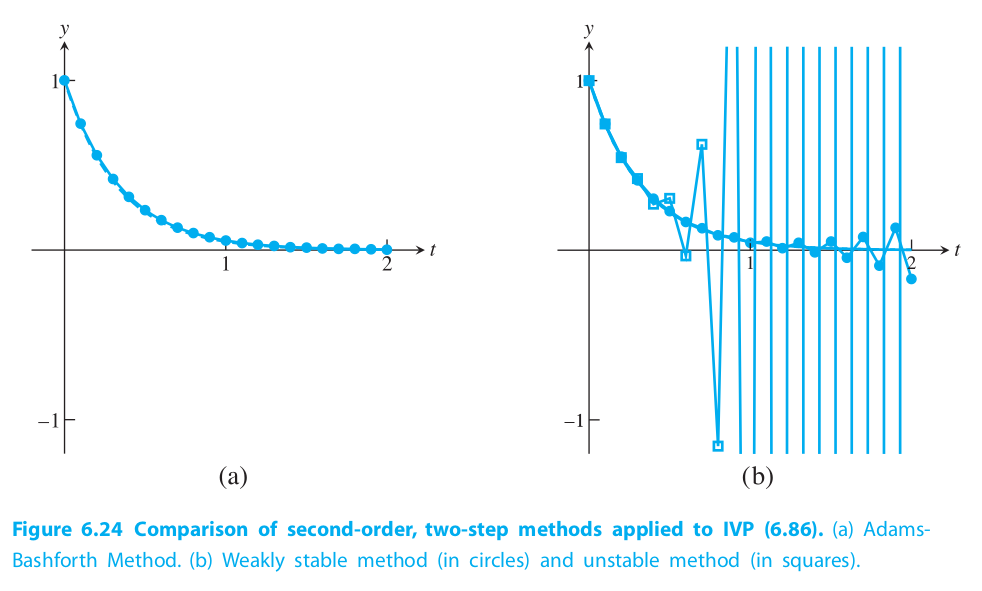

##### <b><font color=grey>definition 6.7</font></b>


a multistep method is <b>consistent</b> if it has order of at least oone. a solver is <b>convergent</b> if the approximate solutions converge to the exact solution for each $t$ as $h \rightarrow 0$.
</br>


##### <b><font color=grey>theorem 6.8</font></b>


(dahlquist) assume correct starting values. then a multistep method is convergent iif it is stable and consistent.
</br>


###### proof


hairer and wanner (1996) at [geneva](https://www.unige.ch/~wanner/DQsem.pdf), [oxford](https://people.maths.ox.ac.uk/trefethen/1all.pdf).
</br>


##### usw


the adams-bashforth methods have root of $1$ and all other roots of $0$. therefore, the adams-bashforth two-step is considered the most stable of the two-steps.
</br></br>

further.
</br>


##### <b>adams-bashforth three-step (order three)</b>


$$w_{i+1} = w_i + \frac{h}{12}[23f_i - 16f_{i-1} + 5f_{i-2}].$$
</br>


##### <b>adams-bashforth four-step (order four)</b>


$$w_{i+1} = w_i + \frac{h}{24}[55f_i - 59f_{i-1} + 37f_{i-2} - 9f_{i-3}].$$
</br>


#### 6.7.3 implicit multistep


if $b_0$ is non-zero, the method is implicit. the simplest implicit method is implicit trapezoid.
</br>


##### <b>implicit trapezoid (order two)</b>


$$w_{i+1} = w_i + \frac{h}{2}[f_{i+1}+ f_i].$$
</br>

if $f_{i+1}$ is evaluated with eulers, then this becomes the explicit trapezoid method. the implicit trapezoid aka adams-moulton one-step.
</br>


##### <b>adams-moulton two-step</b>


$$w_{i+1} = w_i + \frac{h}{12}[5f_{i+1}+ 8f_i - f_{i-1}].$$
</br>


##### usw


comparatively, 1) a stable order three implicit method can be achieved using only two previous steps and 2) local truncation error is smaller for implicit methods; however, 3) implicit methods do require extra effort to evaluate the implicit part.
</br></br>

so use both. explicit methods with implicit methods as a "predictor-corrector" pair. ie, explicit method predicts $w_{i+1}$ which the implicit method uses to calculate $f_{i+1}$. these pairs take approximate twice the computational effort (bc the right hand side $f$ is evaluated for both the prediction and the correction parts of the step); however, accuracy and stability improve.
</br>


a simple predictor-corrector pair is adams-bashforth two-step explicit with adams-moulton one-step implicit.
</br>


###### code


In [ ]:
# from previous lectures

# solver: order 2, trapezoid
def trap_step(t,y,h,ydot):
  s1 = ydot(t,y)
  s2 = ydot(t+h,y+h*s1)
  rc = y+h/2*(s1+s2)
  return rc

# ivp: f(t,y)
ydot = lambda t,y: t*y + pow(t,3) # eg 01

# solution, for error
yact = lambda t: 3*np.exp(t*t/2) - t*t -2

for i in range(20):




am 1step w ab 2step, h=0.05



,t,y_act,w,y'=f
0,0.00,1.00000,1.00000,0.00000
1,0.05,1.00125,1.00125,0.05019
2,0.10,1.00504,1.00505,0.10150
3,0.15,1.01144,1.01146,0.15509
4,0.20,1.02060,1.02064,0.21213
...,...,...,...,...
16,0.80,1.49138,1.49222,1.70578
17,0.85,1.58287,1.58386,1.96041
18,0.90,1.68791,1.68908,2.24918
19,0.95,1.80832,1.80971,2.57660


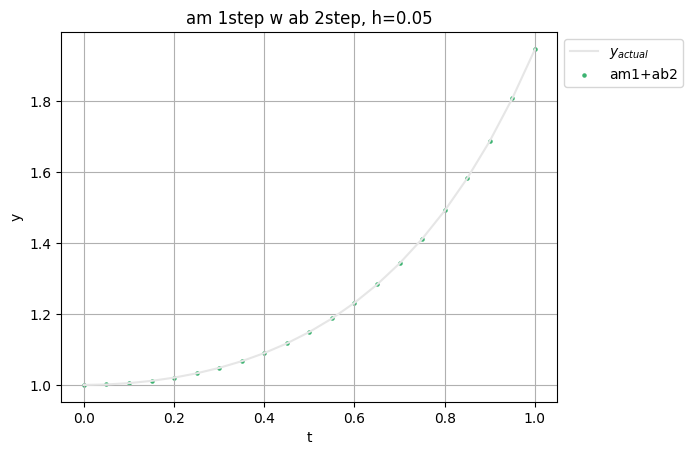

In [ ]:
# program 6.8

# one step of the Adams-Bashforth 2-step method
ab2step = lambda t,i,y,f,h: y[i] + h/2*(3*f[i] - f[i-1])

# one step of an adams-moulton
am1step = lambda t,i,y,f,h: y[i] + h/2*(f[i+1] + f[i])

# ivp: ic,t
ic = 1.
t = [0.,1.]

# n partitions of step-size h
n = 20
h = (t[1]-t[0])/n
n_steps = 2

ds = np.zeros((n+1,4)) # t,y,[w,f]x(am1+ab2)
ds_t,ds_y,ds_f = T,Y,F = 0,2,3

# start-up, n_steps
y_ic = ydot(t[0],ic)
ds[0,:] = [t[0],np.nan,ic,np.nan]
for i in range(n_steps-1):
  ds[i+1,T] = ds[i,T] + h
  ds[i+1,Y] = trap_step(ds[i,T],ds[i,Y],h,ydot)
  ds[i  ,F] = ydot(ds[i,T],ds[i,Y])

# multi-step, after n_steps
for i in range(n_steps-1,n):
  ds[i+1,T] = ds[i,T] + h
  ds[i  ,F] = ydot(ds[i,T],ds[i,Y])
  ds[i+1,Y] = ab2step(ds[:,T],i,ds[:,Y],ds[:,F],h)
  ds[i+1,F] = ydot(ds[i+1,T],ds[i+1,Y])
  ds[i+1,Y] = am1step(ds[:,T],i,ds[:,Y],ds[:,F],h)

# y,actual
ds[:,1] = yact(ds[:,0])

# dataframe from datastore
s_title = "am 1step w ab 2step, h=" + str(h)
print(f"\n\n"+s_title+"\n") # bc pf.style.set_caption() bites in colab atm
pd.set_option("display.max_rows",10)
pd.set_option("display.precision",5)
df = pd.DataFrame(data=ds,columns=["t","y_act","w","y'=f"])
if True: # spreadsheet
  display(df)

if True: # plot
  ax1  = df.plot(x="t",y="y_act",label="$y_{actual}$",color=".9")
  ax11 = df.plot(x="t",y="w",label="am1+ab2",ax=ax1,color="mediumseagreen",marker=".",kind="scatter")
  ax1.set_title(s_title)
  ax1.set_xlabel("t")
  ax1.set_ylabel("y")
  #ax1.axis((0,2,0,1.2))
  ax1.grid('on',which='major',axis='x')
  ax1.grid('on',which='major',axis='y')
  plt.legend(bbox_to_anchor=(1,1))
  plt.show()

##### usw


to derive adams-moulton two-step, do not require $b_0 = 0$. with this extra parameter available, it is possible to match up through degree three terms with a two-step method and local truncation error in the $h^4$ term.
</br></br>

\begin{align}
  a_1 + a_2 &= 1 \\
  -a_2 + b_0 + b_1 + b_2 &= 1 \\
  a_2 + 2b_0 - 2b_2 &= 1 \\
  -a_2 + 3b_0 + 3b_2 &= 1.
\end{align}
</br>

\begin{align}
  a_2 &= 1 - a_1 \\
  b_0 &= \frac{1}{3} + \frac{1}{12}a_1 \\
  b_1 &= \frac{4}{3} - \frac{2}{3}a_1 \\
  b_2 &= \frac{1}{3} - \frac{5}{12}a_1.
\end{align}
</br>

\begin{align}
  y_{i+1} - w_{i+1} &= \frac{h^4}{24}y_i^{(iv)} - \frac{h^4}{24}(4b_0 - 4b_2 + a_2)y_i^{(vi)} + \mathcal{O}(h^5) \\
  &= (1-a_2-4b_0+4b_2)\frac{h^4}{24}y_i^{(iv)} + \mathcal{O}(h^5) \\
  &= -a_1\frac{h^4}{24}y_i^{(iv)} + \mathcal{O}(h^5).
\end{align}
</br>

so if $a_1\le0$, there exists infinitely many order three two-step implicit methods. adams-moulton uses $a_1 = 1$.
</br>


if $a_1 = 0$ then this order four two-step method.
</br>


##### <b>milne-simson</b>


$$w_{i+1} = w_{i-1} + \frac{h}{3}[f_{i+1} + 4f_i + f_{i-1}].$$
</br>


##### usw


derivation of multistep methods can also be done ala approximate integrals. ie, integrate DE $y' = f(t,y)$ over $[t_i,t_{i+1}]$.
</br></br>

$$y(t_{i+1}) - y(t_i) = \int_{t_i}^{t_{i+1}}f(t,y)dt.$$
</br>

apply trapezoid for integration results in
</br></br>

$$y(t_{i+1}) - y(t_i) = \frac{h}{2}(f_{i+1}+f_i) + \mathcal{O}(h^2)$$
</br>

which is the order two trapezoid method for ODEs. approximating with simpsons rule for integration, results in
</br></br>

$$y(t_{i+1}) - y(t_i) = \frac{h}{3}(f_{i+1}+4f_i +f_{i-1}) + \mathcal{O}(h^4)$$
</br>

the order four milne-simpson method. ie, approximate the RHS of an ODE by a polynomial and integrate.
</br></br>



with $a_1 = 1$ and extending previous methods,
</br>


##### <b>adams-moulton three-step (order four)</b>


$$w_{i+1} = w_i + \frac{h}{24}[9f_{i+1} + 19f_i - 5f_{i-1} + f_{i-2}].$$
</br>


##### <b>adams-moulton four-step (order five)</b>


$$w_{i+1} = w_i + \frac{h}{720}[251f_{i+1} + 646f_i - 264f_{i-1} + 106f_{i-2} -19f_{i-3}].$$
</br>


### miscellaney


that adams guy at the [linear multistep entry @wiki](https://en.wikipedia.org/wiki/Linear_multistep_method).
</br>


</br></br></br></br></br></br></br></br></br></br>
</br></br></br></br></br></br></br></br></br></br>
</br></br></br></br></br></br></br></br></br></br>
</br></br></br></br></br></br></br></br></br></br>
</br></br></br></br></br></br></br></br></br></br>
colab, please print everything. the end.

